# Stock Price Prediction Using LSTM 

The project you're working on aims to predict the stock price of PayPal (PYPL) using historical stock data and machine learning techniques. Specifically, it's a time series forecasting problem where you want to predict future stock prices based on the patterns observed in past prices.

The goal of this project is to build a predictive model using the Long Short-Term Memory (LSTM) neural network, which is well-suited for time series data. Additionally, the project includes a backtesting strategy to simulate a trading strategy based on predicted stock prices, to evaluate the potential financial performance of the predictions.

#### Data

The project uses the yfinance library to download historical stock price data for PayPal from January 1, 2015, to January 1, 2023, including:

- Open, high, low, close (OHLC) prices
- Trading volumes

### 1. Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### 2. Load Data

In [3]:
# Download historical data for PayPal
stock_data = yf.download('PYPL', start='2015-01-01', end='2023-01-01')
print("\n--- Historical Stock Data ---")
print(stock_data.head())  

# Adding Moving Averages
stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()  # 20-day moving average
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()  # 50-day moving average
stock_data.dropna(inplace=True)  # Drop rows with NaN values
print("\n--- Stock Data with Moving Averages ---")
print(stock_data[['Close', 'MA20', 'MA50']].tail())  

# Scale the Closing Prices
data = stock_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print("\n--- Scaled Stock Prices ---")
print(scaled_data[:5])  # Inspect the first few scaled prices

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
print(f"\n--- Training Size: {len(train_data)}, Testing Size: {len(test_data)} ---")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


--- Historical Stock Data ---
Price           Close       High        Low       Open   Volume
Ticker           PYPL       PYPL       PYPL       PYPL     PYPL
Date                                                           
2015-07-06  36.709999  39.750000  36.000000  38.000000  5866600
2015-07-07  36.619999  37.810001  36.000000  37.720001  7359000
2015-07-08  34.700001  36.360001  34.529999  36.340000  5387700
2015-07-09  34.500000  35.520000  33.990002  35.099998  3760100
2015-07-10  34.689999  35.189999  33.980000  34.660000  4472800

--- Stock Data with Moving Averages ---
Price           Close     MA20     MA50
Ticker           PYPL                  
Date                                   
2022-12-23  69.029999  73.0455  79.4148
2022-12-27  68.330002  72.4655  79.1720
2022-12-28  67.550003  71.9610  78.8298
2022-12-29  70.559998  71.5685  78.5352
2022-12-30  71.220001  71.2030  78.2702

--- Scaled Stock Prices ---
[[0.01129903]
 [0.01140698]
 [0.01129903]
 [0.00967974]
 [0.0082403

### 3.Creating Sequences for LSTM Input

In [4]:
# Create Sequences for LSTM Input
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences
time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("\n--- Input Shapes for LSTM ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


--- Input Shapes for LSTM ---
X_train shape: (1410, 60, 1), y_train shape: (1410,)
X_test shape: (307, 60, 1), y_test shape: (307,)


### 4. Building the LSTM Model

In [5]:
# Build and Compile the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the Model
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

Epoch 1/20


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0524
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015
Epoch 16/20
23/

### 5. Make Predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


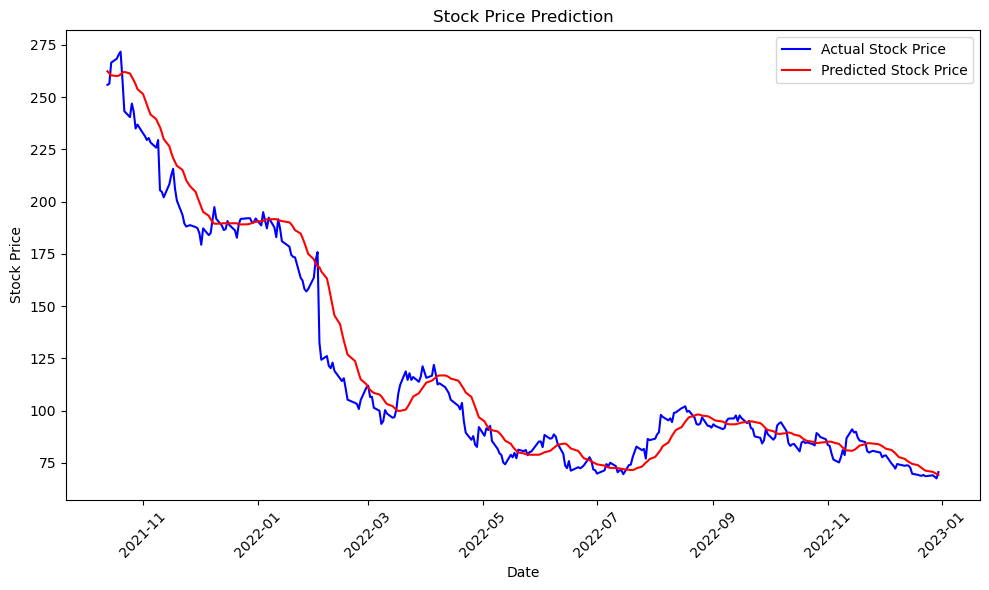

In [6]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform([y_test])

# Plot the Results
plt.figure(figsize=(10, 6))

# CreAte a date index for the test set
test_dates = stock_data.index[-len(y_test_actual[0]):]

plt.plot(test_dates, y_test_actual[0], color='blue', label='Actual Stock Price')
plt.plot(test_dates, predicted_stock_price, color='red', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### 6. Backtesting Strategy:

A simple backtesting strategy is implemented to simulate trading based on the predictions.

In [7]:
# Backtesting Strategy
def backtest_strategy(predictions, actual_prices):
    initial_balance = 10000
    balance = initial_balance
    shares = 0

    for i in range(len(predictions)):
        if predictions[i] > actual_prices[i]:  # Buy condition
            shares += balance // actual_prices[i]
            balance -= shares * actual_prices[i]
        elif predictions[i] < actual_prices[i] and shares > 0:  # Sell condition
            balance += shares * actual_prices[i]
            shares = 0

    final_value = balance + shares * actual_prices[-1]
    return final_value

# Execute backtesting
final_balance = backtest_strategy(predicted_stock_price.flatten(), y_test_actual[0])
print(f'Final balance after backtesting: {final_balance:.2f}')

Final balance after backtesting: 62.28


In [8]:
from sklearn.metrics import mean_absolute_error, r2_score

# After making predictions and converting them back to the original scale
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform([y_test])

# Calculate additional evaluation metrics
mae = mean_absolute_error(y_test_actual[0], predicted_stock_price)
r2 = r2_score(y_test_actual[0], predicted_stock_price)

# Print the evaluation metrics
print(f"\n--- Additional Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Additional Evaluation Metrics ---
Mean Absolute Error (MAE): 7.8064
R-squared (R²): 0.9579


## Conclusion

This project aimed to develop a machine learning model to predict PayPal's stock prices using historical data. The model utilized an LSTM (Long Short-Term Memory) network, which is well-suited for time series forecasting, to predict future stock prices based on past performance. 

#### Evaluation Metrics 

- The Final Balance from Backtesting was $62.28.
- The R-squared (R²) score of 0.9579 indicates that the model explains about 96% of the variance in the stock prices, which is excellent for a forecasting model.

#### Overall Results:

- Despite the modest profit from the backtesting, the model's ability to explain most of the variance in the data (high R²) and low MAE suggests that the LSTM model is effective in capturing the trends and patterns in PayPal's stock price over time.
- The loss in training (approximately 0.0014) shows that the model has been well-optimized, but there could be room for improvement in making it more responsive to market volatility.